In [13]:
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

sns.set(rc={'figure.figsize':(20,15)})

In [3]:
## Importation des datas 

market_campaign = pd.read_csv('/home/dancoh/Yotta/Projet/projet1/code/data.csv', delimiter = ',')
socio_eco = pd.read_csv('/home/dancoh/Documents/socio_eco.csv', delimiter = ',')


def split_date (dataframe):

    col_split = dataframe.DATE.str.split("-")
    n = len(col_split)
    months, years = [], []

    for i in range(n):
        months.append(col_split[i][1])
        years.append(col_split[i][0])
    
    dataframe["YEARS"] = years
    dataframe["MONTHS"] = months

    return dataframe

socio_eco = split_date(socio_eco)
market_campaign = split_date(market_campaign)

market_campaign_merged = market_campaign.merge(socio_eco, how = 'left', on = ["MONTHS", "YEARS"])
market_campaign_merged.drop(columns = 'DATE_y', inplace = True)

market_campaign_merged.SUBSCRIPTION = market_campaign_merged.SUBSCRIPTION.replace(["Yes","No"],[1,0])

In [4]:
market_campaign_merged.head()

,DATE_x,AGE,JOB_TYPE,STATUS,EDUCATION,HAS_DEFAULT,BALANCE,HAS_HOUSING_LOAN,HAS_PERSO_LOAN,CONTACT,...,NB_CONTACT,NB_DAY_LAST_CONTACT,NB_CONTACT_LAST_CAMPAIGN,RESULT_LAST_CAMPAIGN,SUBSCRIPTION,YEARS,MONTHS,EMPLOYMENT_VARIATION_RATE,IDX_CONSUMER_PRICE,IDX_CONSUMER_CONFIDENCE
0,2008-05-05,58,Manager,Marié,Tertiaire,No,2143,Yes,No,NaN,...,1,-1,0,NaN,0,2008,05,1.1,93.994,-36.4
1,2008-05-05,123,Technicien,NaN,Secondaire,No,29,Yes,NaN,NaN,...,1,-1,0,NaN,0,2008,05,1.1,93.994,-36.4
2,2008-05-05,33,Entrepreuneur,Marié,Secondaire,No,2,Yes,Yes,NaN,...,1,-1,0,NaN,0,2008,05,1.1,93.994,-36.4
3,2008-05-05,47,Col bleu,Marié,NaN,No,1506,Yes,No,NaN,...,1,-1,0,NaN,0,2008,05,1.1,93.994,-36.4
4,2008-05-05,33,NaN,Célibataire,NaN,No,1,No,No,NaN,...,1,-1,0,NaN,0,2008,05,1.1,93.994,-36.4


In [5]:
market_campaign_merged.columns

Index(['DATE_x', 'AGE', 'JOB_TYPE', 'STATUS', 'EDUCATION', 'HAS_DEFAULT',
       'BALANCE', 'HAS_HOUSING_LOAN', 'HAS_PERSO_LOAN', 'CONTACT',
       'DURATION_CONTACT', 'NB_CONTACT', 'NB_DAY_LAST_CONTACT',
       'NB_CONTACT_LAST_CAMPAIGN', 'RESULT_LAST_CAMPAIGN', 'SUBSCRIPTION',
       'YEARS', 'MONTHS', 'EMPLOYMENT_VARIATION_RATE', 'IDX_CONSUMER_PRICE',
       'IDX_CONSUMER_CONFIDENCE'],
      dtype='object')

On trace la matrice des corrélations des variables numériques.

In [6]:
market_campaign_merged.describe()

,AGE,BALANCE,DURATION_CONTACT,NB_CONTACT,NB_DAY_LAST_CONTACT,NB_CONTACT_LAST_CAMPAIGN,SUBSCRIPTION,EMPLOYMENT_VARIATION_RATE,IDX_CONSUMER_PRICE,IDX_CONSUMER_CONFIDENCE
count,45136.000000,45136.000000,45136.000000,45136.00000,45136.000000,45136.000000,45136.000000,45136.000000,45136.000000,45136.000000
mean,44.206354,1362.182847,258.050625,2.76573,40.042272,0.575173,0.116382,-0.045179,93.511829,-40.992277
std,19.149653,3046.691765,257.527875,3.10002,99.910200,2.296948,0.320686,1.573232,0.589535,4.995480
min,18.000000,-8019.000000,0.000000,1.00000,-1.000000,0.000000,0.000000,-3.400000,92.201000,-50.000000
25%,33.000000,72.000000,103.000000,1.00000,-1.000000,0.000000,0.000000,-1.800000,92.893000,-45.900000
50%,40.000000,447.500000,180.000000,2.00000,-1.000000,0.000000,0.000000,1.100000,93.444000,-41.800000
75%,50.000000,1425.000000,318.000000,3.00000,-1.000000,0.000000,0.000000,1.400000,93.994000,-36.400000
max,123.000000,102127.000000,4918.000000,63.00000,854.000000,275.000000,1.000000,1.400000,94.601000,-26.900000


In [7]:
market_campaign.isna().sum()

DATE                            0
AGE                             0
JOB_TYPE                      286
STATUS                       1128
EDUCATION                    1853
HAS_DEFAULT                     0
BALANCE                         0
HAS_HOUSING_LOAN                0
HAS_PERSO_LOAN               1354
CONTACT                     13019
DURATION_CONTACT                0
NB_CONTACT                      0
NB_DAY_LAST_CONTACT             0
NB_CONTACT_LAST_CAMPAIGN        0
RESULT_LAST_CAMPAIGN        36939
SUBSCRIPTION                    0
YEARS                           0
MONTHS                          0
dtype: int64

<AxesSubplot:>

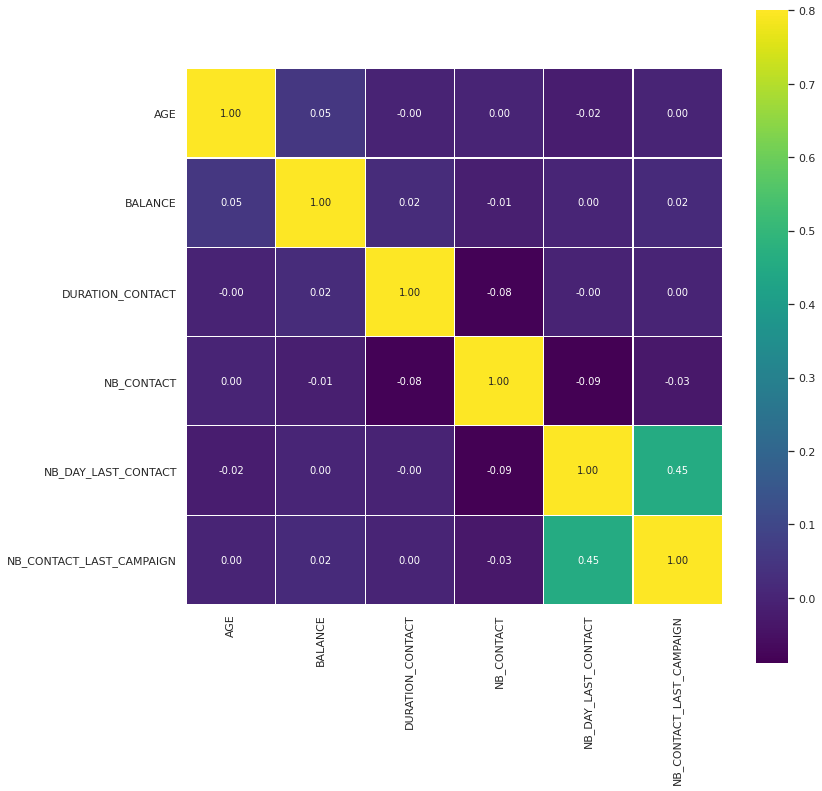

In [8]:
colormap = plt.cm.viridis
cor = market_campaign.corr()
plt.figure(figsize=(12,12))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

Nous remarquons que le dataset est globalement bien rempli mais que 2 variables sortent du lot. Nous avons décidé de supprimer ces 2 variables car elles nous introduirons du biais dans notre futur modèle.
Mais la variable "RESULT_LAST_CAMPAIGN" peut être un indicateur intéressant pour aider le métier à avoir un indicateur quant à la sensibilité du client.

<AxesSubplot:xlabel='AGE', ylabel='Count'>

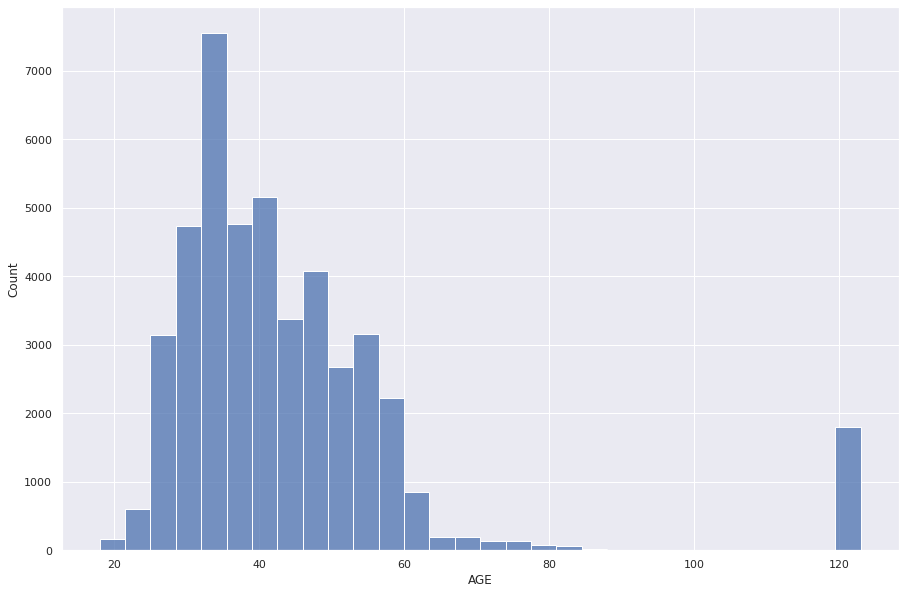

In [9]:
sns.histplot(market_campaign_merged.AGE, bins = 30)

/home/dancoh/.cache/pypoetry/virtualenvs/subscription-forecast-JrvzibXC-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


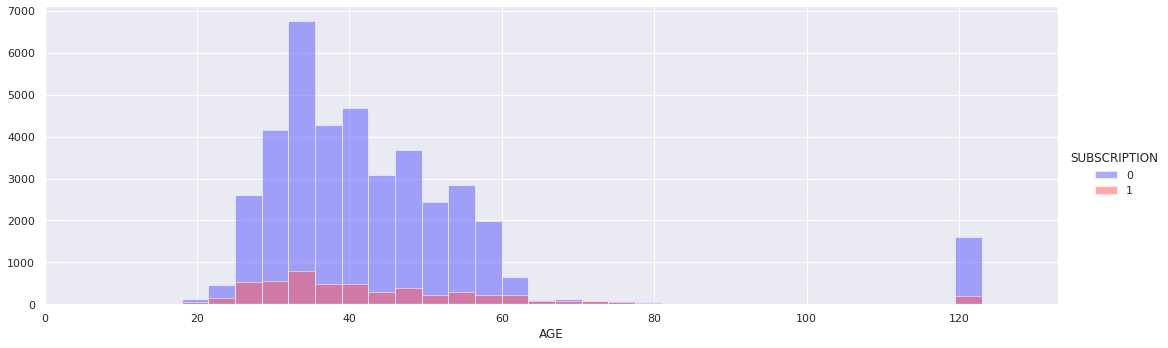

In [19]:
facet = sns.FacetGrid(market_campaign_merged, hue='SUBSCRIPTION',size=5,aspect=3,palette='seismic')
facet.map(plt.hist,'AGE',bins=30,alpha=0.5)
facet.set(xlim=(0,market_campaign_merged.AGE.max()+10))
facet.add_legend()

On observe ici des valeurs pour l'âge qui sont égales à 123. Ceux sont des valeurs manquantes qui ont été initialisées à 123.


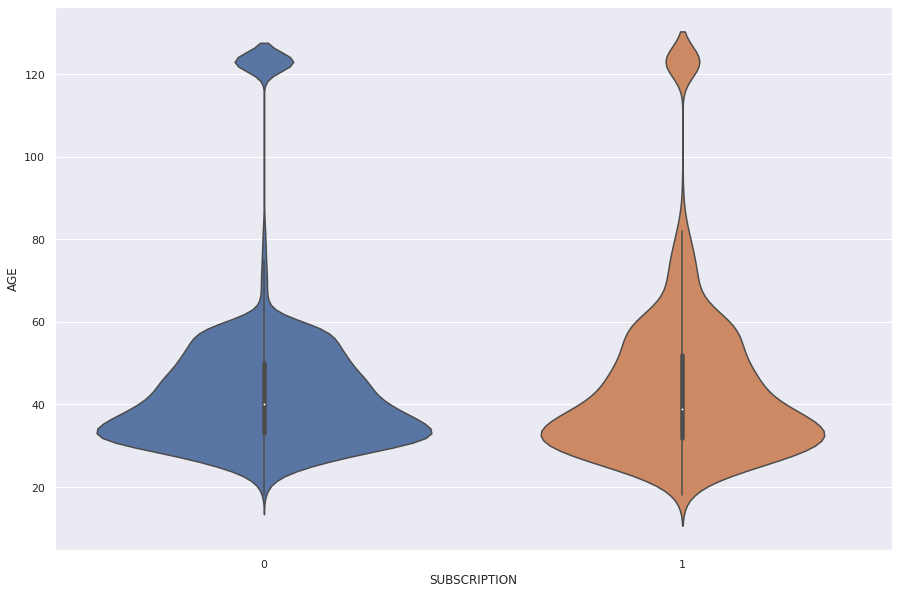

In [10]:
sns.violinplot(x="SUBSCRIPTION",y="AGE", data=market_campaign_merged, whis = 2.0);
plt.show()

Regardons maintenant la répartition de la variable BALANCE

<AxesSubplot:xlabel='BALANCE', ylabel='Count'>

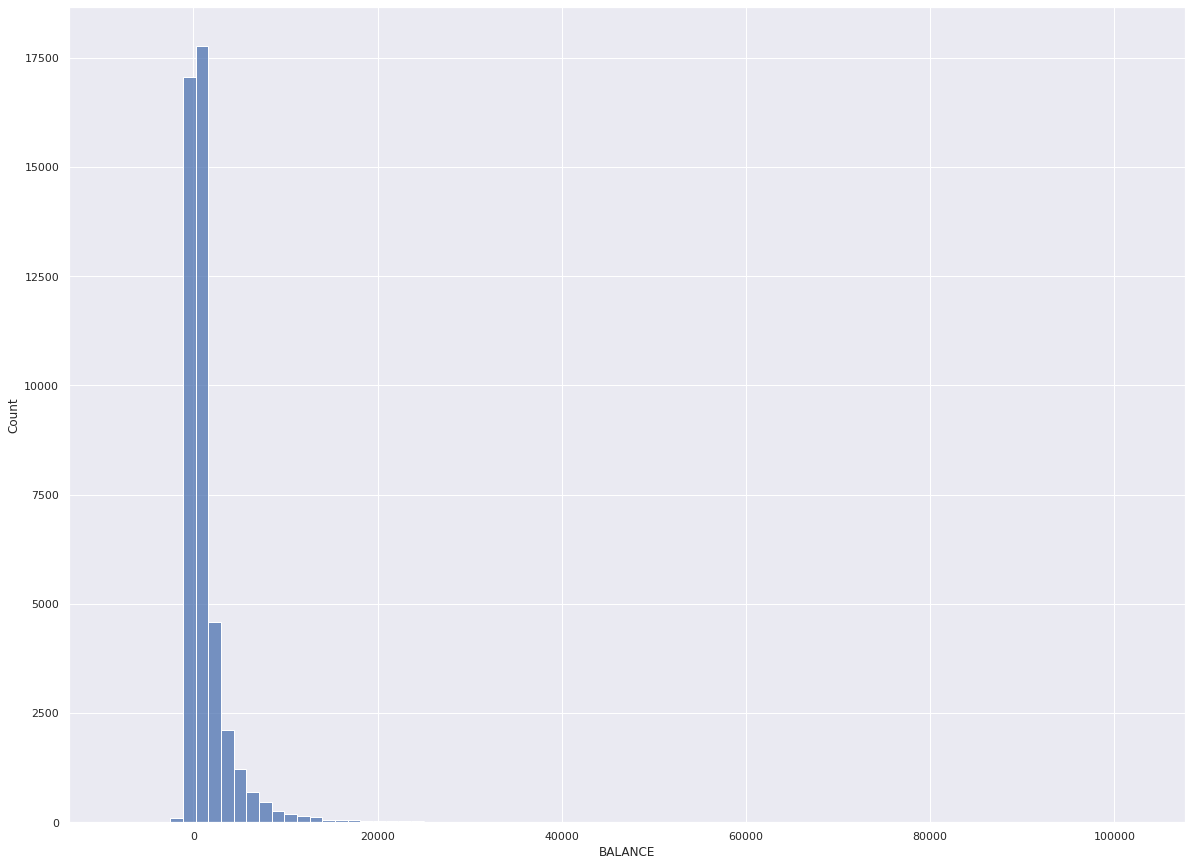

In [23]:
sns.histplot(market_campaign_merged.BALANCE, bins = 80)

Nous remarquons que la principale majorité de notre échantillon est concentrée entre 0 et 5000. Nous avons des balances négatives mais aussi des valeurs extrêmes qui déforment la distribution.

<AxesSubplot:xlabel='JOB_TYPE', ylabel='SUBSCRIPTION'>

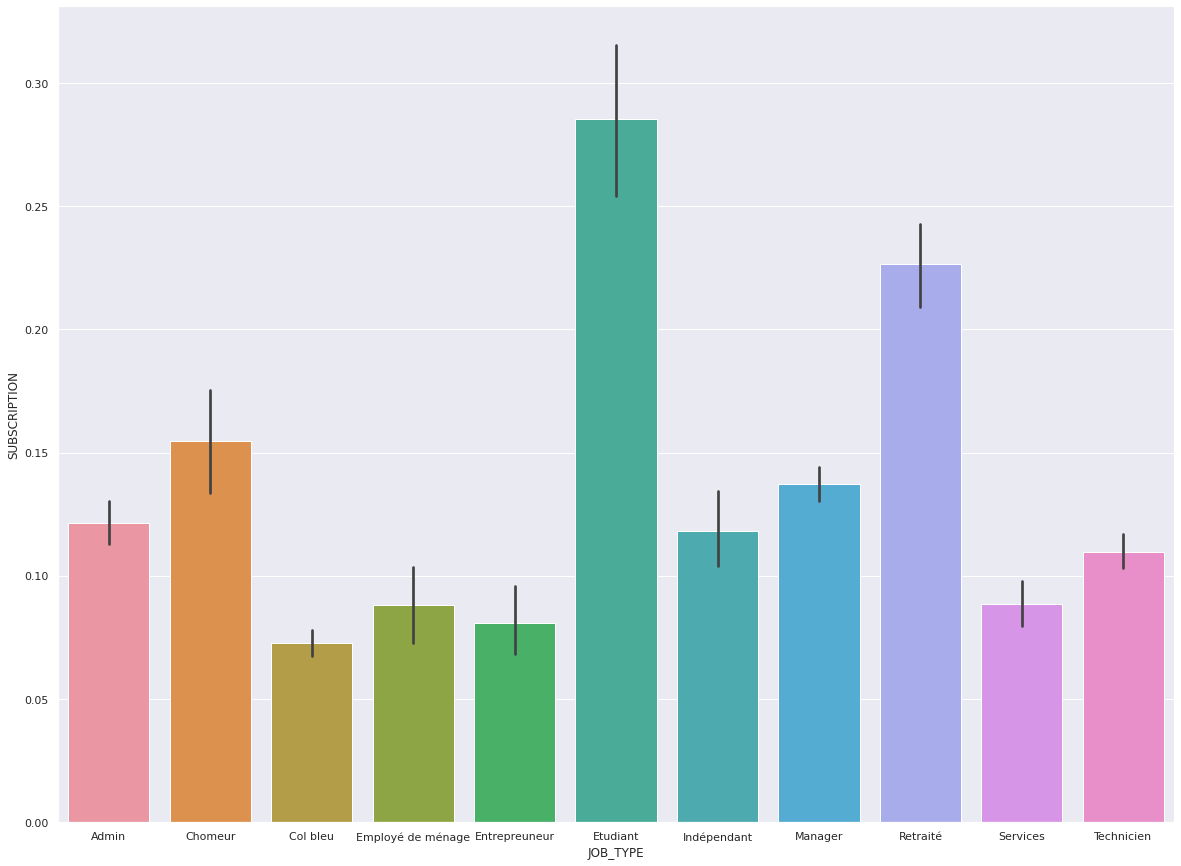

In [14]:
sns.barplot(x = 'JOB_TYPE',y="SUBSCRIPTION", data = market_campaign_merged, 
              order = ["Admin","Chomeur","Col bleu", "Employé de ménage", "Entrepreuneur","Etudiant","Indépendant",
                      "Manager","Retraité","Services","Technicien"])

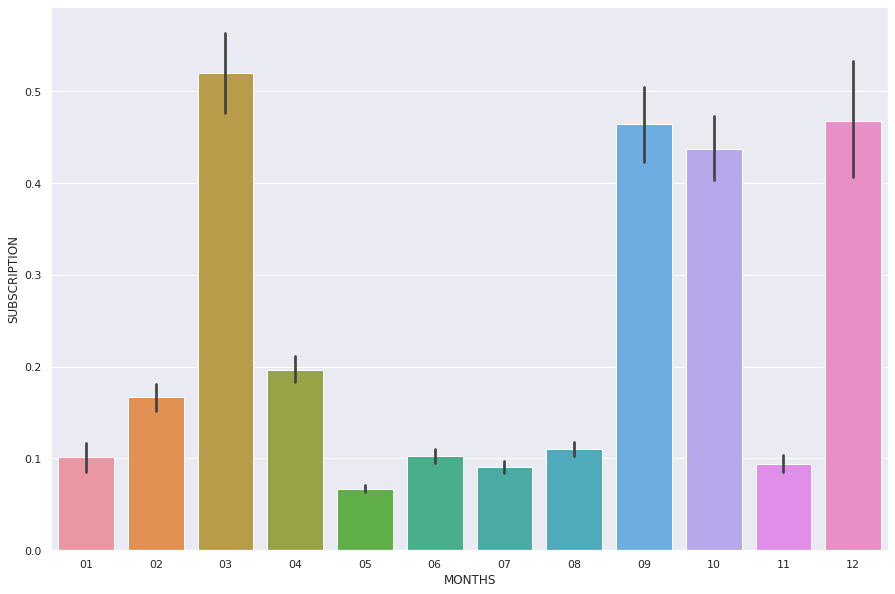

In [12]:
sns.barplot(x = "MONTHS",y = "SUBSCRIPTION", data = market_campaign_merged,
              order = ["01","02","03","04","05","06","07","08","09","10","11","12"])
plt.show()

On remarque ici que le taux de souscription est plus élevé de mai à août, mais faible d'octobre à janvier, dû à la période de fin d'année qui est une période de stress économique (impôts, taxes ...) et de fêtes.

<AxesSubplot:xlabel='STATUS', ylabel='SUBSCRIPTION'>

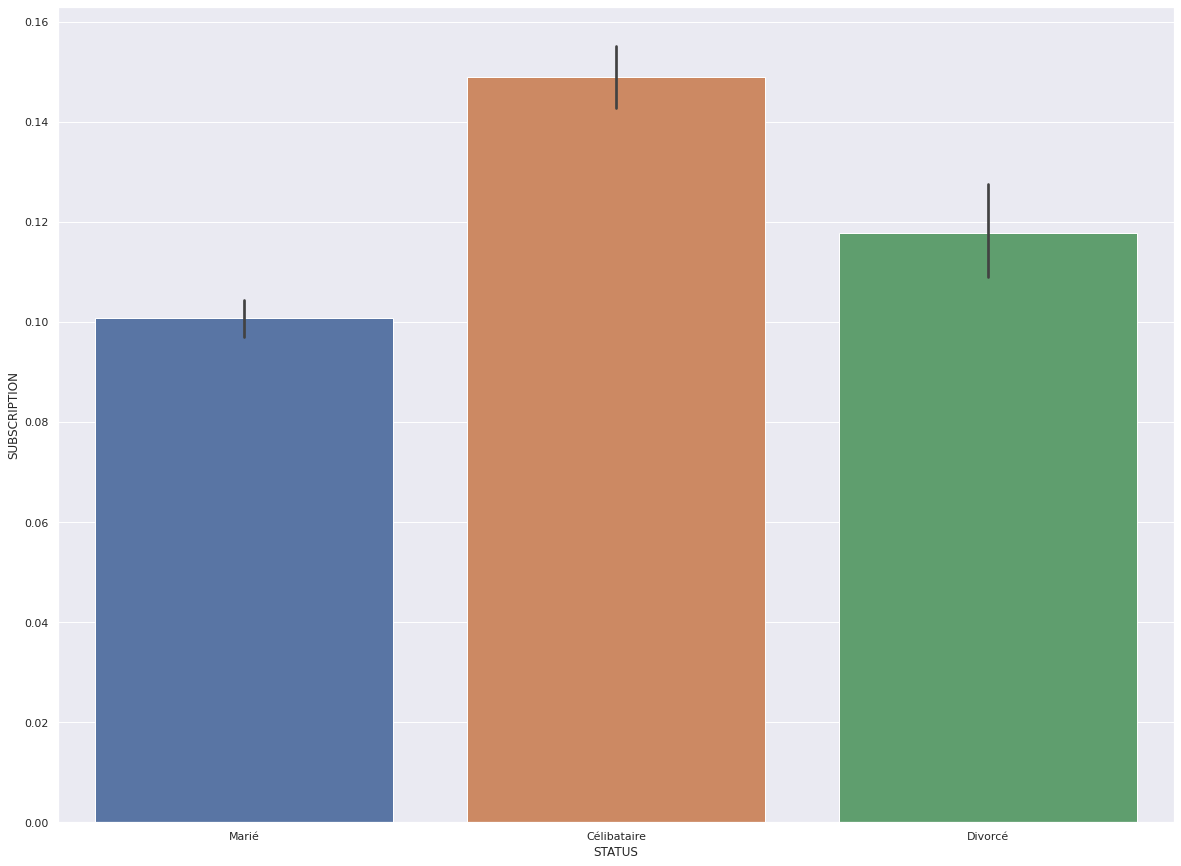

In [24]:
sub_status = market_campaign_merged.dropna(subset = ['STATUS'])

sns.barplot(x = 'STATUS', y = 'SUBSCRIPTION', data = sub_status)

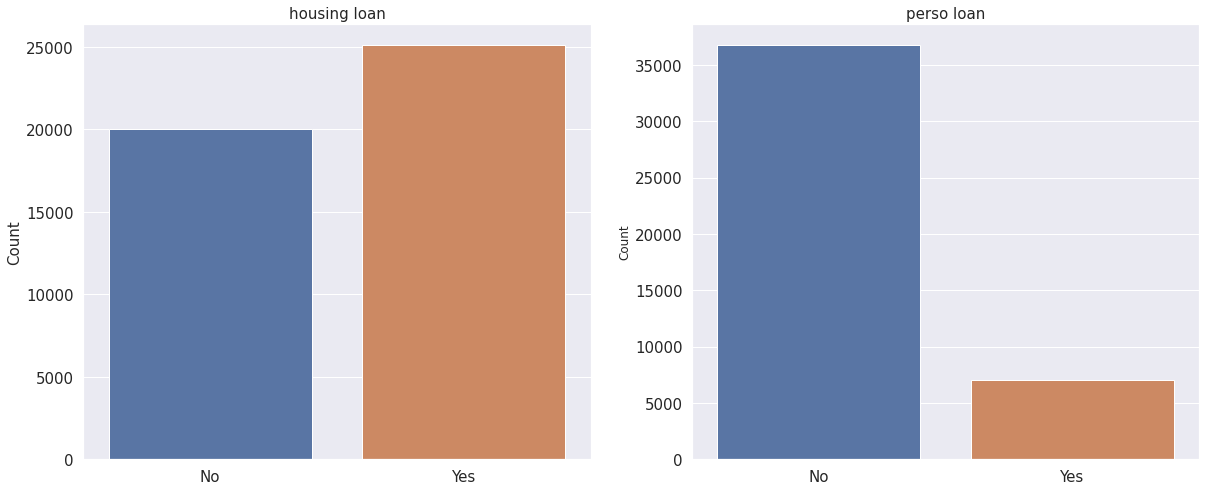

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

sns.countplot(x = 'HAS_HOUSING_LOAN', data = market_campaign_merged, ax = ax1, order = ['No', 'Yes'])
ax1.set_title('housing loan', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize=15)
ax1.tick_params(labelsize=15)

sns.countplot(x = 'HAS_PERSO_LOAN', data = market_campaign_merged, ax = ax2, order = ['No','Yes'])
ax2.set_title('perso loan', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Count')
ax2.tick_params(labelsize=15)

<AxesSubplot:xlabel='EDUCATION', ylabel='SUBSCRIPTION'>

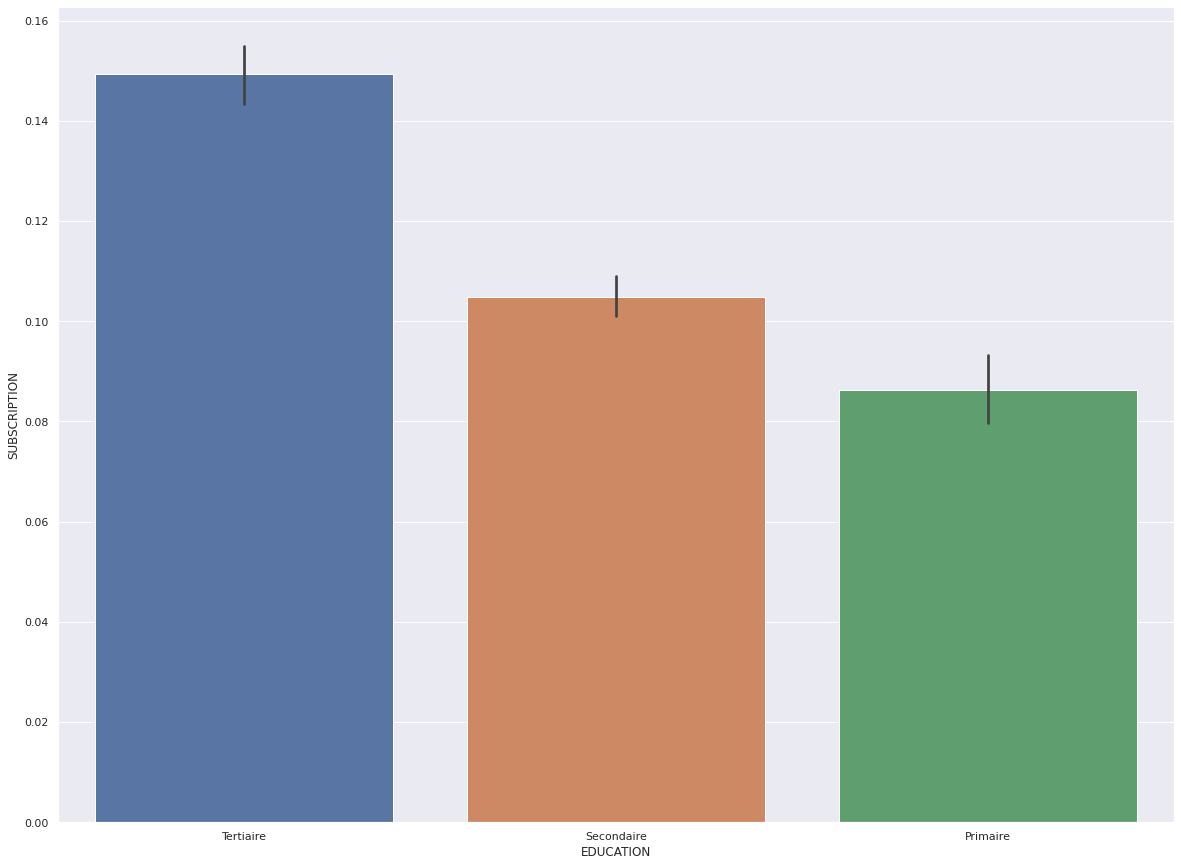

In [37]:
sns.barplot(x = 'EDUCATION', y = 'SUBSCRIPTION', data = market_campaign_merged)

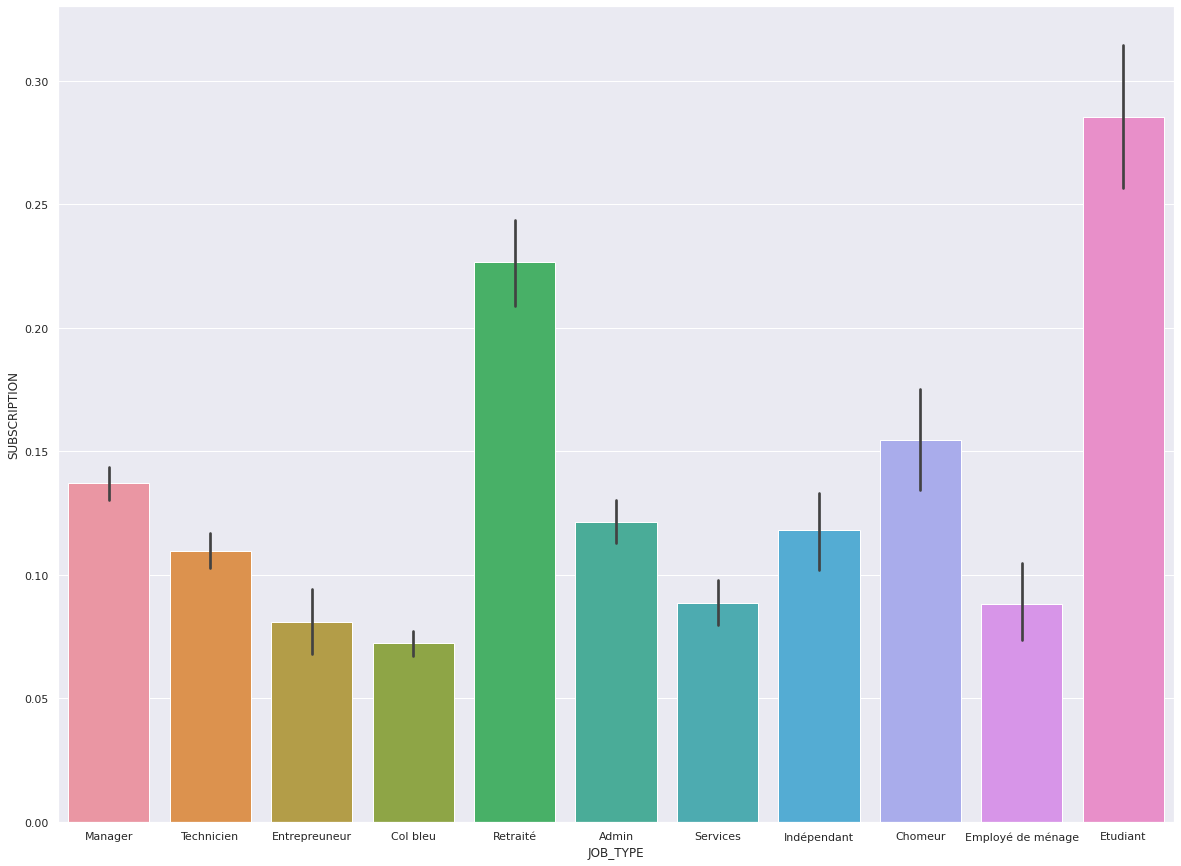

In [44]:
sns.barplot(x = 'JOB_TYPE', y = "SUBSCRIPTION", data = market_campaign_merged.dropna(subset = ['JOB_TYPE']))
plt.show()